# Introduction to Apache Spark lab, Lab 3: Binary Classification with Spark ML

### In this notebook, we will explore Binary Classification using Spark ML. We will exploit Spark ML's high-level APIs built on top of DataFrames to create and tune machine learning pipelines. Spark ML Pipelines enable combining multiple algorithms into a single pipeline or workflow. We will heavily utilize Spark ML's feature transformers to convert, modify and scale the features that will be used to develop the machine learning model. Finally, we will evaluate and cross validate our model to demonstrate the process of determining a best fit model.

### The binary classification demo will utilize the famous Titanic dataset, which has been used for Kaggle competitions and can be downloaded here. There is no need to download the data manually as it is downloaded directly within the noteboook.
https://www.kaggle.com/c/titanic/data


### The Titanic data set was chosen for this binary classification demonstration because it contains both text based and numeric features that are both continuous and categorical. This will give us the opportunity to explore and utilize a number of feature transformers available in Spark ML.
     
          

![IBM Logo](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSzlUYaJ9xykGC-N5PijcV_eDBGCXy_pMn7sy6ymrVypmJ22q5ZmA)

## Table of contents

1. [Install needed libraries](#libraries)<br/>
2. [Get the Data](#getdata)<br/>
3. [Prepare and clean the data](#prepare)<br/>
    3.1 [Remove unneeded columns](#remove)<br/>
4. [Transform the data](#transform)<br/>
    4.1 [Gender and Embarkation](#stringindexer)<br/>
    4.2 [Age and Fare](#bucketizer)<br/>
5. [Build the Model](#build)<br/>
6. [Split the data into train and test sets](#split)<br/>
7. [Test the Model](#test)<br/>
8. [Tune the Model](#tune)<br/>
9. [Predict imaginary passenger](#predict)<br/>
10. [Random Forest](#randomforest)<br/>
11. [Summary](#summary)<br/>

## Verify Spark version and existence of Spark and Spark SQL contexts

In [1]:
print('The spark version is {}.'.format(spark.version))

The spark version is 2.1.0.


<a id="libraries"></a>
## 1 - Import required Spark libraries 


#### After executing this block, you should see a message saying that the `Pixiedust database opened successfully`.

In [2]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import Bucketizer
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import Normalizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

#import pixiedust display module
from pixiedust.display import *

Pixiedust database opened successfully


<a id="getdata"></a>
## 2 - Download Data

In [3]:
!rm -f Titanic.csv
!wget https://ibm.box.com/shared/static/crceca9g1ym3nl0hwaxa5c0j0m3e19l8.csv -O Titanic.csv -q
!ls -l Titanic.csv

-rw------- 1 s3df-710d3d40018814-e108c032744f users 61194 Sep 19 13:19 Titanic.csv


### Read data in as a DataFrame
### Source data is in CSV format and includes a header. We will ask Spark to infer the schema/data types.

In [4]:
loadTitanicData = sqlContext.read.format("org.apache.spark.sql.execution.datasources.csv.CSVFileFormat").option("header", "true").option("inferSchema", "true").load("Titanic.csv")

<a id="prepare"></a>
## 3. Prepare and shape the data

PixieDust is an open-source IBM library which can be used to easily and flexibly `display` data.

Use PixieDust to examine the schema (click on the Schema line).   Try differing displays of the data using PixieDust.

For example, try showing a histogram of `fare` or `age` or `pclass`.    Change the renderer and see what happens.
<br>
 <div class="panel-group" id="accordion-3">
  <div class="panel panel-default">
    <div class="panel-heading">
      <h4 class="panel-title">
        <a data-toggle="collapse" data-parent="#accordion-3" href="#collapse1-3">
        Hint 1</a>
      </h4>
    </div>
    <div id="collapse1-3" class="panel-collapse collapse">
      <div class="panel-body">Select the Chart icon and select Histogram</div>
    </div>
  </div>
  <div class="panel panel-default">
    <div class="panel-heading">
      <h4 class="panel-title">
        <a data-toggle="collapse" data-parent="#accordion-3" href="#collapse2-3">
        Hint 2</a>
      </h4>
    </div>
    <div id="collapse2-3" class="panel-collapse collapse">
      <div class="panel-body">Select the Options button.   Drag the age (or fare or class) field to the values column.   Change number of rows to display to more than the number of rows read in (1400 will do)</div>
    </div>
  </div>
  <div class="panel panel-default">
    <div class="panel-heading">
      <h4 class="panel-title">
        <a data-toggle="collapse" data-parent="#accordion-3" href="#collapse3-3">
        Hint 3</a>
      </h4>
    </div>
    <div id="collapse3-3" class="panel-collapse collapse">
      <div class="panel-body">Change the renderer (dropdown on upper right) to something else, such as `seaborn` or `bokeh`</div>
    </div>
  </div>
</div> 


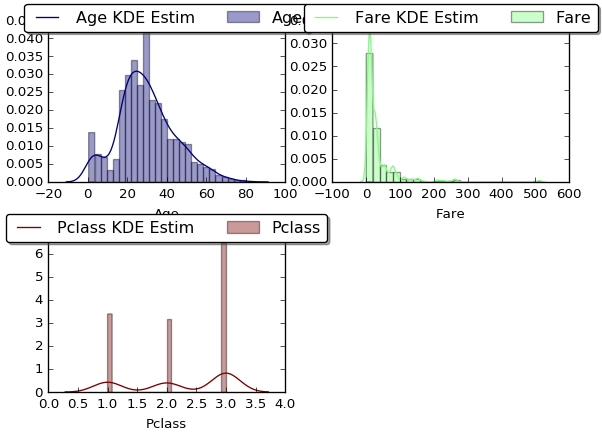

In [5]:
display(loadTitanicData)

<a id="remove"></a>
## 3.1 - Drop unwanted columns and rows with null or invalid data.

In [6]:
loadTitanicData = loadTitanicData.drop("PassengerId").drop("Name").drop("Ticket").drop("Cabin").dropna(how="any", subset=("Age", "Embarked"))

##  We will use the 'Survived' column as a label for training the machine learning model
#### Spark ML requires that that the labels are data type Double, so we will cast the  column as Double (it was inferred as Integer when read into Spark).

In [7]:
LabeledTitanicData = (loadTitanicData.withColumn("SurvivedTemp", loadTitanicData["Survived"]
    .cast("Double")).drop("Survived")
    .withColumnRenamed("SurvivedTemp", "Survived"))

## Show the labeled data

In [8]:
LabeledTitanicData.sample(False, 0.01, seed=0).show(5)

+------+------+----+-----+-----+-------+--------+--------+
|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|Survived|
+------+------+----+-----+-----+-------+--------+--------+
|     1|female|19.0|    0|    2|26.2833|       S|     1.0|
|     1|  male|65.0|    0|    0|  26.55|       S|     0.0|
|     3|female|36.0|    1|    0|   17.4|       S|     1.0|
|     3|  male|24.5|    0|    0|   8.05|       S|     0.0|
|     1|  male|48.0|    1|    0|   52.0|       S|     1.0|
+------+------+----+-----+-----+-------+--------+--------+



## Print some record counts

In [9]:
print('The total number of rows is {}.'.format(LabeledTitanicData.count()))
print('The number of rows labeled Not Survived is {}.'.format(LabeledTitanicData.filter(LabeledTitanicData['Survived'] == 0).count()))
print('The number of rows labeled Survived is {}.'.format(LabeledTitanicData.filter(LabeledTitanicData['Survived'] == 1).count()))

The total number of rows is 712.
The number of rows labeled Not Survived is 424.
The number of rows labeled Survived is 288.


## Show the schema of the labeled data

In [10]:
LabeledTitanicData.printSchema()

root
 |-- Pclass: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Embarked: string (nullable = true)
 |-- Survived: double (nullable = true)



<a id="transform"></a>
## 4. Transform the data

Certain data fields need to be transformed before building the model.   This can be for several reasons ranging from needing to convert String values to numeric values or shaping data into different formats.

<a id="stringindexer"></a>
## 4.1 Use <a href="https://spark.apache.org/docs/latest/ml-features.html#stringindexer">StringIndexer</a> to transform gender and embarked values

StringIndexer is a transformer that encodes a string column to a column of indices. The indices are ordered by value frequencies, so the most frequent value gets index 0. If the input column is numeric, it is cast to string first. 

For the Titanic data set, we will index the Sex/Gender column as well as the Embarked column, which specifies at which  port the passenger boarded the ship.## StringIndexer

In [11]:
SexIndexer = StringIndexer(inputCol="Sex", outputCol="SexIndex")
EmbarkedIndexer = StringIndexer(inputCol="Embarked", outputCol="EmbarkedIndex")

<a id="bucketizer"></a>
## 4.2 <a href="https://spark.apache.org/docs/latest/ml-features.html#bucketizer">Bucketizer</a> is a transformer that transforms a column of continuous features to a column of feature buckets, where the buckets are by a splits parameter. 

For the Titanic data set, we will index the Age and Fare features.

<br/>
<div class="panel-group" id="accordion-42">
  <div class="panel panel-default">
    <div class="panel-heading">
      <h4 class="panel-title">
        <a data-toggle="collapse" data-parent="#accordion-42" href="#collapse1-42">
        Advanced Optional</a>
      </h4>
    </div>
    <div id="collapse1-42" class="panel-collapse collapse">
      <div class="panel-body">After completing the lab, note the prediction percentage then come back and change the values for either Bucketizer and re-run the kernel [Kernel->Restart and Run All].   Note the change in prediction accuracy.</div>
    </div>
  </div>
</div> 

In [12]:
AgeBucketSplits = [0.0, 6.0, 12.0, 18.0, 40.0, 65.0, 80.0, float("inf")]
AgeBucket = Bucketizer(splits=AgeBucketSplits, inputCol="Age", outputCol="AgeBucket")

FareBucketSplits = [0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 80.0, 100.0, float("inf")]
FareBucket = Bucketizer(splits=FareBucketSplits, inputCol="Fare", outputCol="FareBucket")

<a id="build"></a>
## 5. Building the Model

## <a href="https://spark.apache.org/docs/latest/ml-features.html#vectorassembler">VectorAssembler</a> is a transformer that combines a given list of columns in the order specified into a single vector column in order to train a model.

<br/>
<div class="panel-group" id="accordion-5">
  <div class="panel panel-default">
    <div class="panel-heading">
      <h4 class="panel-title">
        <a data-toggle="collapse" data-parent="#accordion-5" href="#collapse1-5">
        Advanced Optional</a>
      </h4>
    </div>
    <div id="collapse1-5" class="panel-collapse collapse">
      <div class="panel-body">After completing the lab, note the prediction percentage then come back and remove some of the values in the assembler (i.e. remove sibsp, pclass and parch or remove SexIndex) and re-run the kernel [Kernel->Restart and Run All].   Note the change in prediction accuracy.</div>
    </div>
  </div>
</div> 

In [13]:
assembler = VectorAssembler(inputCols= ["SexIndex", "EmbarkedIndex", "AgeBucket", "FareBucket", "SibSp", "Pclass", "Parch"], outputCol="features")

## Normalizer is a Transformer which transforms a dataset of Vector rows, normalizing each Vector to have unit norm
### This normalization can help standardize your input data and improve the behavior of learning algorithms.

In [14]:
normalizer = Normalizer(inputCol="features", outputCol="normFeatures", p=1.0)

## Logistic regression is a popular method to predict a binary response
### It is a special case of Generalized Linear models that predicts the probability of an outcome.

In [15]:
lr = LogisticRegression(featuresCol="normFeatures", labelCol="Survived", predictionCol="prediction", maxIter=10, regParam=0.1, elasticNetParam=0.8)

## A Pipeline is a sequence of stages where each stage is either a Transformer or an Estimator
### These stages are run in order and the input DataFrame is transformed as it passes through each stage. 

### In machine learning, it is common to run a sequence of algorithms to process and learn from data.

In [16]:
pipeline = Pipeline(stages=[SexIndexer, EmbarkedIndexer, AgeBucket,FareBucket, assembler, normalizer, lr])

<a id="split"></a>
## 6 - Split the data into training (90%) and testing (10%) sets using <a href="https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.randomSplit">random_split()</a>

Set seed to 1 in order to make certain this is repeatable.
<br>
 <div class="panel-group" id="accordion-6">
  <div class="panel panel-default">
    <div class="panel-heading">
      <h4 class="panel-title">
        <a data-toggle="collapse" data-parent="#accordion-6" href="#collapse1-6">
        Hint 1</a>
      </h4>
    </div>
    <div id="collapse1-6" class="panel-collapse collapse">
      <div class="panel-body">train, test = LabeledTitanicData.randomSplit()</div>
    </div>
  </div>
  <div class="panel panel-default">
    <div class="panel-heading">
      <h4 class="panel-title">
        <a data-toggle="collapse" data-parent="#accordion-6" href="#collapse2-6">
        Hint 2</a>
      </h4>
    </div>
    <div id="collapse2-6" class="panel-collapse collapse">
      <div class="panel-body">train, test = LabeledTitanicData.randomSplit([??,??], seed=??)</div>
    </div>
  </div>
  <div class="panel panel-default">
    <div class="panel-heading">
      <h4 class="panel-title">
        <a data-toggle="collapse" data-parent="#accordion-6" href="#collapse3-6">
        Solution</a>
      </h4>
    </div>
    <div id="collapse3-6" class="panel-collapse collapse">
      <div class="panel-body">train, test = LabeledTitanicData.randomSplit([90.0,10.0], seed=1)</div>
    </div>
  </div>
</div> 

In [18]:
train, test = LabeledTitanicData.randomSplit([90.0,10.0], seed=1)
train.cache()
test.cache()
print('The number of records in the traininig data set is {}.'.format(train.count()))
print('The number of rows labeled Not Survived in the training data set is {}.'.format(train.filter(train['Survived'] == 0).count()))
print('The number of rows labeled Survived in the training data set is {}.'.format(train.filter(train['Survived'] == 1).count()))
train.sample(False, 0.01, seed=0).show(5)
print('')

print('The number of records in the test data set is {}.'.format(test.count()))
print('The number of rows labeled Not Survived in the test data set is {}.'.format(test.filter(train['Survived'] == 0).count()))
print('The number of rows labeled Survived in the test data set is {}.'.format(test.filter(train['Survived'] == 1).count()))
test.sample(False, 0.1, seed=0).show(5)

The number of records in the traininig data set is 628.
The number of rows labeled Not Survived in the training data set is 365.
The number of rows labeled Survived in the training data set is 263.
+------+------+----+-----+-----+-------+--------+--------+
|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|Survived|
+------+------+----+-----+-----+-------+--------+--------+
|     1|  male|36.0|    0|    0|26.2875|       S|     1.0|
|     3|female|22.0|    0|    0|   7.75|       Q|     1.0|
|     3|  male|16.0|    4|    1|39.6875|       S|     0.0|
|     3|  male|27.0|    0|    0|  6.975|       S|     1.0|
|     3|  male|31.0|    0|    0|  7.775|       S|     0.0|
+------+------+----+-----+-----+-------+--------+--------+


The number of records in the test data set is 84.
The number of rows labeled Not Survived in the test data set is 59.
The number of rows labeled Survived in the test data set is 25.
+------+------+----+-----+-----+------+--------+--------+
|Pclass|   Sex| Age|SibSp|Par

## Fit the pipeline to the training data

In [19]:
model = pipeline.fit(train)

<a id="test"></a>
## 7 - Make predictions on passengers in the Test data set
### Keep in mind that the model has not seen the data in the test data set

In [20]:
predictions = model.transform(test)

## Show results

In [21]:
predictions.sample(False, 0.1, seed=0).show(5)

+------+------+----+-----+-----+------+--------+--------+--------+-------------+---------+----------+--------------------+--------------------+--------------------+--------------------+----------+
|Pclass|   Sex| Age|SibSp|Parch|  Fare|Embarked|Survived|SexIndex|EmbarkedIndex|AgeBucket|FareBucket|            features|        normFeatures|       rawPrediction|         probability|prediction|
+------+------+----+-----+-----+------+--------+--------+--------+-------------+---------+----------+--------------------+--------------------+--------------------+--------------------+----------+
|     2|female|29.0|    0|    0|  10.5|       S|     1.0|     1.0|          0.0|      3.0|       1.0|[1.0,0.0,3.0,1.0,...|[0.14285714285714...|[-0.7707480103402...|[0.31631731882287...|       1.0|
|     2|  male|51.0|    0|    0|12.525|       S|     0.0|     0.0|          0.0|      4.0|       1.0|(7,[2,3,5],[4.0,1...|(7,[2,3,5],[0.571...|[0.96711625250958...|[0.72454433275422...|       0.0|
|     3|female|

In [22]:
print('The number of predictions labeled Not Survived is {}.'.format(predictions.filter(predictions['prediction'] == 0).count()))
print('The number of predictions labeled Survived is {}.'.format(predictions.filter(predictions['prediction'] == 1).count()))

The number of predictions labeled Not Survived is 59.
The number of predictions labeled Survived is 25.


In [23]:
(predictions.filter("Survived = 0.0")
     .select("Sex", "Age", "Fare", "Embarked", "Pclass", "Parch", "SibSp", "Survived", "prediction")
     .sample(False, 0.1, seed=0).show(5))

(predictions.filter("Survived = 1.0")
     .select("Sex", "Age", "Fare", "Embarked", "Pclass", "Parch", "SibSp", "Survived", "prediction")
     .sample(False, 0.5, seed=0).show(5))

+------+----+------+--------+------+-----+-----+--------+----------+
|   Sex| Age|  Fare|Embarked|Pclass|Parch|SibSp|Survived|prediction|
+------+----+------+--------+------+-----+-----+--------+----------+
|female| 8.0|21.075|       S|     3|    1|    3|     0.0|       1.0|
|  male|20.5|  7.25|       S|     3|    0|    0|     0.0|       0.0|
|  male|26.0|7.8875|       S|     3|    0|    0|     0.0|       0.0|
|  male|30.0|  8.05|       S|     3|    0|    0|     0.0|       0.0|
|  male|33.0|   9.5|       S|     3|    0|    0|     0.0|       0.0|
+------+----+------+--------+------+-----+-----+--------+----------+
only showing top 5 rows

+------+----+--------+--------+------+-----+-----+--------+----------+
|   Sex| Age|    Fare|Embarked|Pclass|Parch|SibSp|Survived|prediction|
+------+----+--------+--------+------+-----+-----+--------+----------+
|female|23.0| 113.275|       C|     1|    0|    1|     1.0|       1.0|
|  male|35.0|512.3292|       C|     1|    0|    0|     1.0|       0.0|

## Create an evaluator for the binary classification using area under the ROC Curve as the evaluation metric

### Receiver operating characteristic (ROC) is a graphical plot that illustrates the performance of a binary classifier system as its discrimination threshold is varied

The curve is created by plotting the true positive rate against the false positive rate at various threshold settings. The ROC curve is thus the sensitivity as a function of fall-out. The area under the ROC curve is useful for comparing and selecting the best machine learning model for a given data set. A model with an area under the ROC curve score near 1 has very good performance. A model with a score near 0.5 is about as good as flipping a coin.

In [24]:
evaluator = BinaryClassificationEvaluator().setLabelCol("Survived").setMetricName("areaUnderROC")
print('Area under the ROC curve = {}.'.format(evaluator.evaluate(predictions)))

Area under the ROC curve = 0.8145762711864406.


<a id="tune"></a>
## 8 - Tune Hyperparameters
### Generate hyperparameter combinations by taking the cross product of some parameter values

Spark ML algorithms provide many hyperparameters for tuning models. These hyperparameters are distinct from the model parameters being optimized by Spark ML itself. Hyperparameter tuning is accomplished by choosing the best set of parameters based on model performance on test data that the model was not trained with. All combinations of hyperparameters specified will be tried in order to find the one that leads to the model with the best evaluation result.

## Build a Parameter Grid specifying what parameters and values will be evaluated in order to determine the best combination

In [25]:
paramGrid = (ParamGridBuilder().addGrid(lr.regParam, [0.0, 0.1, 0.3])
                 .addGrid(lr.elasticNetParam, [0.0, 0.8, 1.0])
                 .addGrid(normalizer.p, [1.0, 2.0])
                 .build())

## Create a cross validator to tune the pipeline with the generated parameter grid
Spark ML provides for cross-validation for hyperparameter tuning. Cross-validation attempts to fit the underlying estimator with user-specified combinations of parameters, cross-evaluate the fitted models, and output the best one.

In [26]:
cv = CrossValidator().setEstimator(pipeline).setEvaluator(evaluator).setEstimatorParamMaps(paramGrid).setNumFolds(10)

## Cross-evaluate the ML Pipeline to find the best model
### using the area under the ROC evaluator and hyperparameters specified in the parameter grid

In [27]:
cvModel = cv.fit(LabeledTitanicData)
print('Area under the ROC curve for best fitted model = {}.'.format(evaluator.evaluate(cvModel.transform(LabeledTitanicData))))

Area under the ROC curve for best fitted model = 0.8548955057651987.


## Let's see what improvement we achieve by tuning the hyperparameters using cross-evaluation 

In [28]:
print('Area under the ROC curve for non-tuned model = {}.'.format(evaluator.evaluate(predictions)))
print('Area under the ROC curve for best fitted model = {}.'.format(evaluator.evaluate(cvModel.transform(LabeledTitanicData))))
print('Improvement = {0:0.2f}%'.format((evaluator.evaluate(cvModel.transform(LabeledTitanicData)) - evaluator.evaluate(predictions)) *100 / evaluator.evaluate(predictions)))

Area under the ROC curve for non-tuned model = 0.8145762711864406.
Area under the ROC curve for best fitted model = 0.8548955057651987.
Improvement = 4.95%


## Make improved predictions using the Cross-validated model
### Using the Test data set and DataFrame API

In [29]:
cvModel.transform(test).select("Survived", "prediction").sample(False, 0.1, seed=0).show(10)

+--------+----------+
|Survived|prediction|
+--------+----------+
|     1.0|       1.0|
|     0.0|       0.0|
|     1.0|       1.0|
|     0.0|       1.0|
|     0.0|       0.0|
|     0.0|       0.0|
|     0.0|       0.0|
+--------+----------+



### Like above, but now using SQL

In [30]:
# create temporary table
cvModel.transform(test).createOrReplaceTempView("cvModelPredictions")
spark.sql("SELECT Survived, prediction FROM cvModelPredictions").sample(False, 0.1, seed=0).show(10)

+--------+----------+
|Survived|prediction|
+--------+----------+
|     1.0|       1.0|
|     0.0|       0.0|
|     1.0|       1.0|
|     0.0|       1.0|
|     0.0|       0.0|
|     0.0|       0.0|
|     0.0|       0.0|
+--------+----------+



<a id="predict"></a>
## 9 - Make a prediction on an imaginary passenger

## Define the imaginary passenger's features

In [31]:
SexValue = 'female'
AgeValue = 40.0
FareValue = 15.0
EmbarkedValue = 'C'
PclassValue = 2
SibSpValue = 1
ParchValue = 1

PredictionFeatures = (spark.createDataFrame([(SexValue, AgeValue, FareValue, EmbarkedValue, PclassValue, SibSpValue, ParchValue)],
    ['Sex', 'Age', 'Fare', 'Embarked', 'Pclass', 'SibSp', 'Parch']))
PredictionFeatures.show()

+------+----+----+--------+------+-----+-----+
|   Sex| Age|Fare|Embarked|Pclass|SibSp|Parch|
+------+----+----+--------+------+-----+-----+
|female|40.0|15.0|       C|     2|    1|    1|
+------+----+----+--------+------+-----+-----+



## Predict whether the imaginary person would have survived
### using the best fit model

In [32]:
SurvivedOrNotPrediction = cvModel.transform(PredictionFeatures)
SurvivedOrNotPrediction.select('rawPrediction', 'probability', 'prediction').show(1, False)

+----------------------------------------+---------------------------------------+----------+
|rawPrediction                           |probability                            |prediction|
+----------------------------------------+---------------------------------------+----------+
|[0.1968334246904791,-0.1968334246904791]|[0.549050094397346,0.45094990560265397]|0.0       |
+----------------------------------------+---------------------------------------+----------+



## Display Prediction Result

In [33]:
SurvivedOrNot = SurvivedOrNotPrediction.select("prediction").first()[0]
if SurvivedOrNot == 0.0:
    print("Did NOT Survive")
elif(SurvivedOrNot == 1.0):
    print("Did Survive!!!")
else:
    print("Invalid Prediction")

Did NOT Survive


<a id="randomforest"></a>
## 10 - Let's take a quick look at applying the feature engineering performed above to a Random Forest Model
### Random forests are ensembles of decision trees. They combine many decision trees in order to reduce the risk of overfitting.
### We won't do any hyperparamter tuning in this example, but just show how to create and evaluate the model using all default hyperparameters

In [34]:
from pyspark.ml.classification import RandomForestClassificationModel, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import IndexToString

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer().setInputCol("Survived").setOutputCol("indexedLabel").fit(LabeledTitanicData)

# Train a RandomForest model
rf = RandomForestClassifier().setLabelCol("indexedLabel").setFeaturesCol("features").setNumTrees(20)

# Convert indexed labels back to original labels.
labelConverter = IndexToString().setInputCol("prediction").setOutputCol("predictedLabel").setLabels(labelIndexer.labels)

# Create new Pipeline using the RandomForest model and all the same feature transformers used above for logistic regression
pipelineRF = Pipeline().setStages([labelIndexer, SexIndexer, EmbarkedIndexer, AgeBucket, FareBucket, assembler, normalizer, rf, labelConverter])

# Train model.
modelRF = pipelineRF.fit(train)

# Make predictions.
predictionsRF = modelRF.transform(test)

# Select example rows to display.
predictionsRF.select("predictedLabel", "Survived", "features").show(10)

# Select (prediction, true label) and compute test error
evaluatorRF = MulticlassClassificationEvaluator().setLabelCol("Survived").setPredictionCol("prediction").setMetricName("accuracy")
accuracyRF = evaluatorRF.evaluate(predictionsRF)
print("Accuracy = %g" % accuracyRF)
print("Test Error = %g" % (1.0 - accuracyRF))

rfModel = modelRF.stages[7]
print(rfModel)  # summary only

+--------------+--------+--------------------+
|predictedLabel|Survived|            features|
+--------------+--------+--------------------+
|           1.0|     1.0|[1.0,0.0,2.0,3.0,...|
|           1.0|     1.0|[1.0,1.0,3.0,7.0,...|
|           1.0|     1.0|[1.0,0.0,3.0,6.0,...|
|           1.0|     1.0|[1.0,1.0,3.0,7.0,...|
|           1.0|     1.0|[1.0,0.0,3.0,6.0,...|
|           1.0|     1.0|[1.0,0.0,3.0,5.0,...|
|           0.0|     1.0|[0.0,0.0,3.0,5.0,...|
|           0.0|     1.0|(7,[2,3,5],[3.0,3...|
|           0.0|     0.0|[0.0,1.0,3.0,6.0,...|
|           0.0|     0.0| (7,[2,5],[3.0,1.0])|
+--------------+--------+--------------------+
only showing top 10 rows

Accuracy = 0.809524
Test Error = 0.190476
RandomForestClassificationModel (uid=rfc_e4b62c8e768a) with 20 trees


<a id="summary"></a>
![IBM Logo](http://www-03.ibm.com/press/img/Large_IBM_Logo_TN.jpg)

You created a predictive model that predicts survival probabilities for passengers on the Titanic.

  - Load the data
  - Cleaned the data
  - Created transformers to shape the data
  - Created a model using Pipeline
  - Split the data into training and test sets
  - Tested the model
  - Tuned the model
  - Tested the model on an imaginary passenger
  - Build a second model using Random Forest
  